Backbone selection contains 1712 atoms
Protein selection contains 6977 atoms
Ligand selection contains 0 atoms
Selection 'ligand' is empty. Skipping.


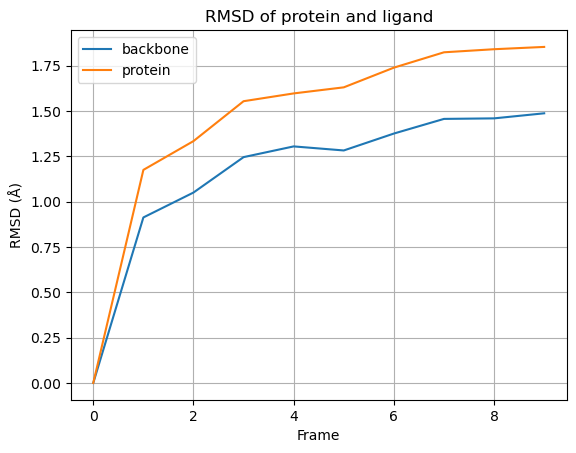

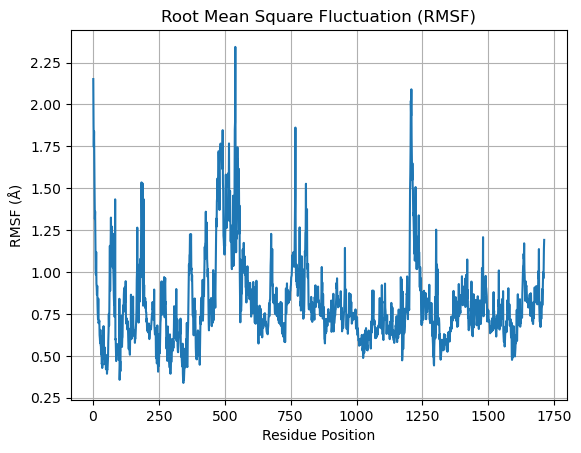

ValueError: Shape of passed values is (10, 5136), indices imply (10, 3)

In [12]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms, pca
from MDAnalysis.analysis.rms import RMSF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Clear warnings
warnings.filterwarnings("ignore")


def compute_rmsd(universe, selections, ref_frame=0):
    """Compute RMSD for multiple selections."""
    rmsd_results = {}
    for label, sel in selections.items():
        atomgroup = universe.select_atoms(sel)
        if len(atomgroup) == 0:
            print(f"Selection '{label}' is empty. Skipping.")
            continue
        rmsd_analysis = rms.RMSD(universe, universe, select=sel, ref_frame=ref_frame)
        rmsd_analysis.run()
        rmsd_results[label] = rmsd_analysis.results.rmsd[:, 2]  # RMSD values
    return rmsd_results


def compute_rmsf(universe, selection):
    """Compute RMSF for a specific selection."""
    atomgroup = universe.select_atoms(selection)
    rmsf_analysis = RMSF(atomgroup).run()
    residues = np.arange(len(rmsf_analysis.rmsf)) + 1  # Residue index starts at 1
    return residues, rmsf_analysis.rmsf


def compute_pca(universe, selection="backbone"):
    """Perform Principal Component Analysis (PCA)."""
    atomgroup = universe.select_atoms(selection)
    pca_analysis = pca.PCA(universe, select=selection).run()
    pca_data = pca_analysis.transform(atomgroup)  # Transform to PCA space
    return pca_data, pca_analysis.variance


def plot_rmsd(rmsd_results):
    """Plot RMSD for multiple selections."""
    plt.figure()
    for label, rmsd_values in rmsd_results.items():
        plt.plot(rmsd_values, label=label)
    plt.title("RMSD of protein and ligand")
    plt.xlabel("Frame")
    plt.ylabel("RMSD (Å)")
    plt.legend()
    plt.grid()
    plt.savefig("rmsd_plot.png")
    plt.show()


def plot_rmsf(residues, rmsf_values):
    """Plot RMSF for residues."""
    plt.figure()
    plt.plot(residues, rmsf_values)
    plt.title("Root Mean Square Fluctuation (RMSF)")
    plt.xlabel("Residue Position")
    plt.ylabel("RMSF (Å)")
    plt.grid()
    plt.savefig("rmsf_plot.png")
    plt.show()


def plot_pca(pca_data, pca_variance):
    """Plot PCA results and variance."""
    plt.figure(figsize=(8, 6))
    
    # Plot first 2 principal components
    plt.scatter(pca_data[:, 0], pca_data[:, 1], alpha=0.7, c="blue", s=10)
    plt.title("PCA: Principal Component 1 vs 2")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()
    plt.savefig("pca_scatter.png")
    plt.show()
    
    # Plot variance explained by each component
    plt.figure(figsize=(8, 6))
    plt.bar(np.arange(len(pca_variance)) + 1, pca_variance * 100, color="blue")
    plt.title("PCA Variance Explained")
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Explained (%)")
    plt.grid()
    plt.savefig("pca_variance.png")
    plt.show()


def main():
    # Load the trajectory
    topology_file = "data/topology.pdb"
    trajectory_file = "data/trajectory.xtc"
    universe = mda.Universe(topology_file, trajectory_file)

    # Validate selections
    print(f"Backbone selection contains {len(universe.select_atoms('backbone'))} atoms")
    print(f"Protein selection contains {len(universe.select_atoms('protein'))} atoms")
    print(f"Ligand selection contains {len(universe.select_atoms('resname IQO'))} atoms")

    # 1. RMSD calculations
    selections = {
        "backbone": "backbone",
        "protein": "protein",
        "ligand": "resname IQO"  # Adjust to use your ligand's residue name
    }
    rmsd_results = compute_rmsd(universe, selections)
    plot_rmsd(rmsd_results)

    # 2. RMSF calculations
    residues, rmsf_values = compute_rmsf(universe, "backbone")
    rmsf_df = pd.DataFrame({"Residue": residues, "RMSF (Å)": rmsf_values})
    rmsf_df.to_csv("rmsf_results.csv", index=False)
    plot_rmsf(residues, rmsf_values)

    # 3. PCA calculations
    pca_data, pca_variance = compute_pca(universe, selection="backbone")
    pca_df = pd.DataFrame(pca_data, columns=["PC1", "PC2", "PC3"])
    pca_df.to_csv("pca_results.csv", index=False)
    pca_variance_df = pd.DataFrame({"Component": np.arange(1, len(pca_variance) + 1),
                                    "Variance Explained (%)": pca_variance * 100})
    pca_variance_df.to_csv("pca_variance.csv", index=False)
    plot_pca(pca_data, pca_variance)

    print("Analysis complete. Results saved as:")
    print("1. RMSD: rmsd_plot.png")
    print("2. RMSF: rmsf_plot.png and rmsf_results.csv")
    print("3. PCA: pca_scatter.png, pca_variance.png, pca_results.csv, and pca_variance.csv")


if __name__ == "__main__":
    main()


In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")


def detect_ligand_resname(universe):
    """Automatically detect the ligand's resname."""
    # Select unique resnames excluding standard residues
    standard_residues = {"03P"}
    all_resnames = set(universe.residues.resnames)
    ligand_resnames = all_resnames - standard_residues
    if len(ligand_resnames) == 0:
        raise ValueError("No ligand detected in the topology.")
    return ligand_resnames.pop()  # Return the first detected ligand resname


def compute_rmsd(universe, selections, ref_frame=0):
    """Compute RMSD for multiple selections."""
    rmsd_results = {}
    for label, sel in selections.items():
        atomgroup = universe.select_atoms(sel)
        if len(atomgroup) == 0:
            print(f"Selection '{label}' is empty. Skipping.")
            continue
        rmsd_analysis = rms.RMSD(universe, universe, select=sel, ref_frame=ref_frame)
        rmsd_analysis.run()
        rmsd_results[label] = rmsd_analysis.results.rmsd[:, 2]  # RMSD values
    return rmsd_results


def plot_rmsd(rmsd_results):
    """Plot RMSD for multiple selections."""
    plt.figure()
    for label, rmsd_values in rmsd_results.items():
        plt.plot(rmsd_values, label=label)
    plt.title("RMSD of protein and ligand")
    plt.xlabel("Frame")
    plt.ylabel("RMSD (Å)")
    plt.legend()
    plt.grid()
    plt.savefig("rmsd_plot_dynamic.png")
    plt.show()


def main():
    # Load the trajectory
    topology_file = "data/topology.pdb"
    trajectory_file = "data/trajectory.xtc"
    universe = mda.Universe(topology_file, trajectory_file)

    # Automatically detect the ligand resname
    ligand_resname = detect_ligand_resname(universe)
    print(f"Detected ligand resname: {ligand_resname}")

    # Validate selections
    print(f"Backbone selection contains {len(universe.select_atoms('backbone'))} atoms")
    print(f"Protein selection contains {len(universe.select_atoms('protein'))} atoms")
    print(f"Ligand selection contains {len(universe.select_atoms(f'resname {ligand_resname}'))} atoms")

    # RMSD calculations
    selections = {
        "backbone": "backbone",
        "protein": "protein",
        "ligand": f"resname {ligand_resname}"  # Use dynamically detected ligand resname
    }
    rmsd_results = compute_rmsd(universe, selections)
    plot_rmsd(rmsd_results)


if __name__ == "__main__":
    main()
